In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import lib
from lib import data_dis, data_ref, data_vst

import numpy as np
from ksvd import ApproximateKSVD
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

In [46]:
image_ref = np.fromfile('data/nu.bin', dtype=np.float64).reshape(100,100).T / 10
image_vst = np.fromfile('data/fz.bin', dtype=np.float64).reshape(100,100).T
image_dis = np.fromfile('data/z.bin', dtype=np.float64).reshape(100,100).T / 10

In [47]:
results = {}
results['reference'] = image_ref
results['distorted'] = image_dis
results['vst'] = image_vst

In [48]:
lib.filter_image(image_vst, results)

/home/alexkkir/ai-masters/linal/project/lib/blocks_github.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides
CSS:   1%|▏         | 122/9409 [00:00<00:07, 1212.09it/s]

MAE: 0.730, Nonzero: 1


SS: 100%|██████████| 9409/9409 [00:53<00:00, 177.02it/s]


{'reference': array([[ 9.3,  9.2,  9.7, ..., 12.6, 11.9, 11.4],
        [10.1, 10.2, 10.8, ..., 12.4, 11.8, 11.4],
        [10.8, 11.1, 11. , ..., 12.1, 11.5, 11.2],
        ...,
        [ 9.3,  9.4,  9.4, ..., 14.9, 14.9, 14.8],
        [ 9.5,  9.5,  9.3, ..., 15. , 14.9, 14.8],
        [ 9.6,  9.7,  9.5, ..., 15. , 15. , 14.9]]),
 'distorted': array([[10.72405194,  8.61624396, 10.99104412, ..., 12.51082881,
         10.20145436, 12.55398305],
        [ 9.66064175, 10.7313938 , 11.32074627, ..., 11.07479585,
          9.31210688, 10.56859779],
        [10.91711465, 12.54149992, 11.39707508, ..., 11.4812206 ,
         12.8008645 ,  9.80626726],
        ...,
        [ 9.69417343,  6.18573917,  8.88373592, ..., 13.00065499,
         15.42817273, 16.28079582],
        [ 8.34816454, 10.67218117,  9.03618348, ..., 14.65076763,
         15.99224108, 13.32548016],
        [ 9.5365338 ,  8.68423255,  8.05615052, ..., 14.86049633,
         14.80851633, 14.06794677]]),
 'vst': array([[ 9.0849909

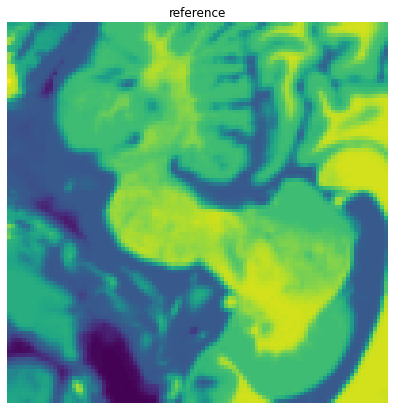

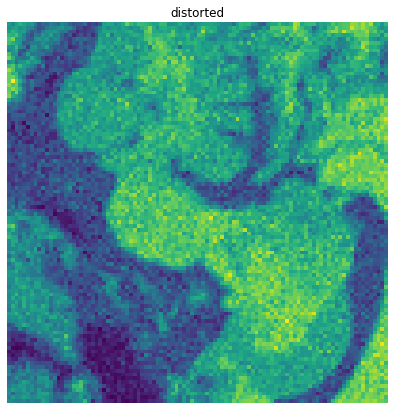

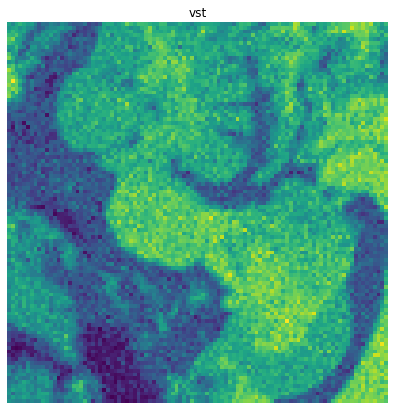

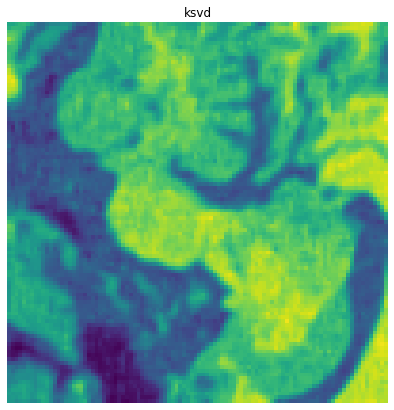

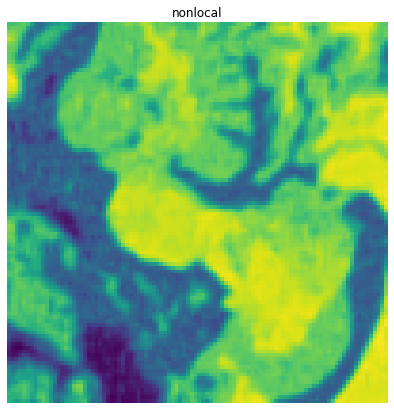

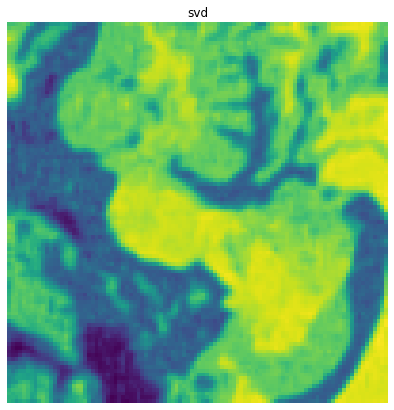

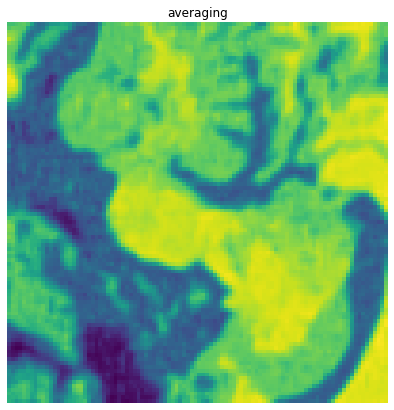

In [49]:
for name in results:
    lib.plot_image(results[name], title=name, size=7)

In [83]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from lpips import LPIPS
import torch
from DISTS_pytorch import DISTS

dists = DISTS()
lpips = LPIPS('vgg')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/alexkkir/anaconda3/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [86]:
dists(torch.Tensor(results['distorted'][None, None, ...]), torch.Tensor(results['reference'][None, None, ...]))

tensor(0.2485, grad_fn=<RsubBackward1>)

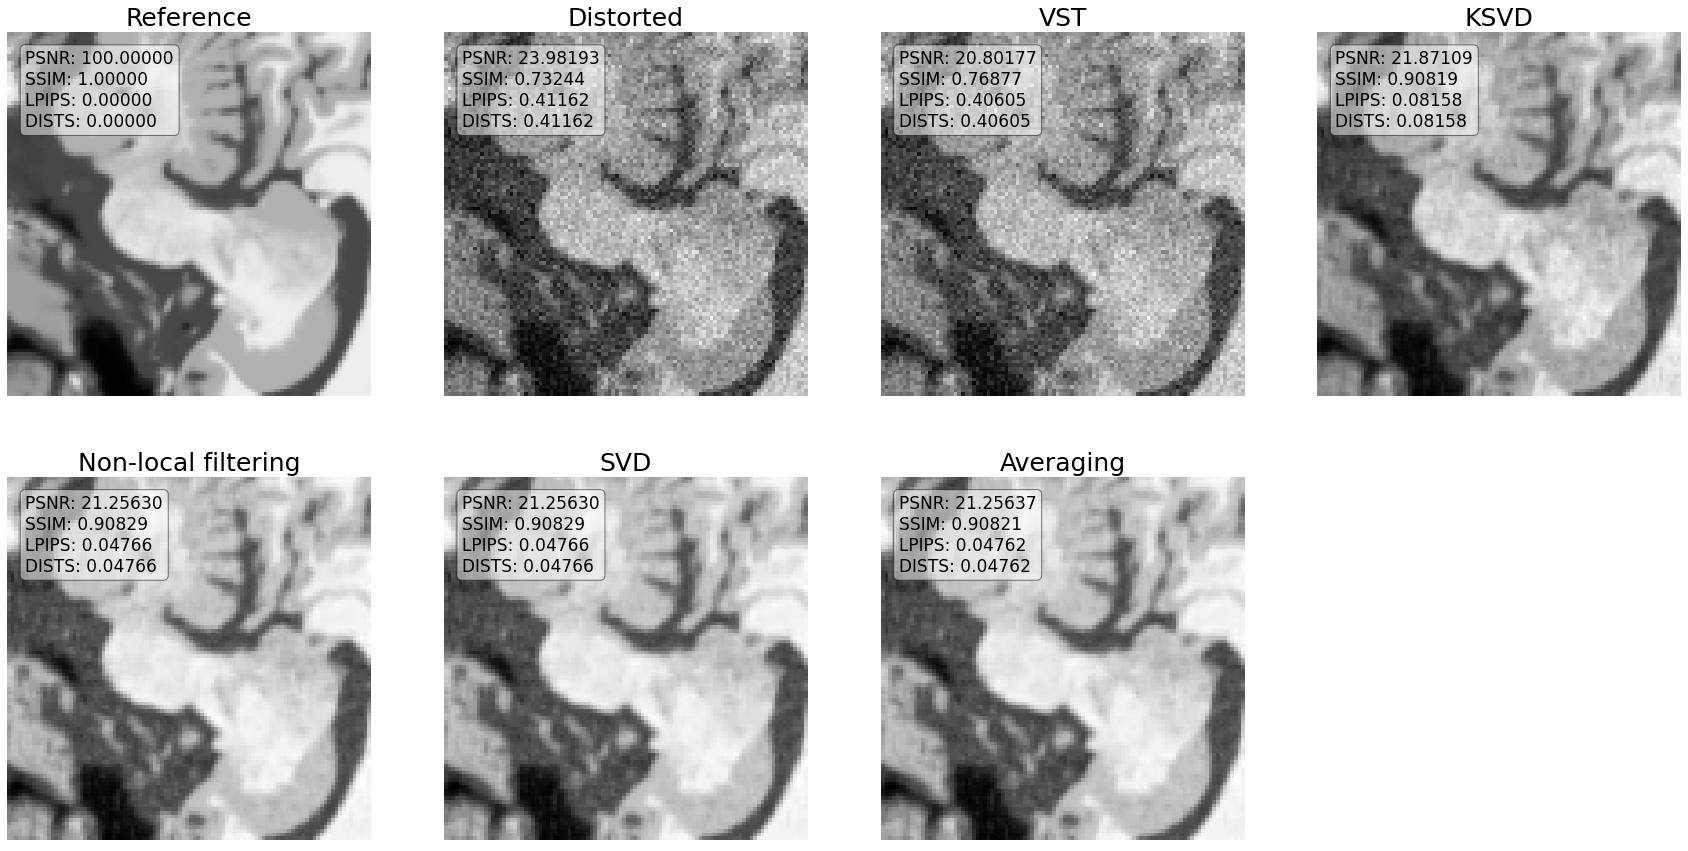

In [100]:
def calc_metrics(ref, dis):
    divider = 20
    ref  = ref / 20
    dis = dis / 20
    out = {}
    out['PSNR'] = min(100, peak_signal_noise_ratio(ref, dis))
    out['SSIM'] = structural_similarity(ref, dis)
    out['LPIPS'] = float(lpips(torch.Tensor(ref), torch.Tensor(dis))[0, 0, 0])
    out['DISTS'] = float(lpips(torch.Tensor(ref)[None, None, ...], torch.Tensor(dis))[0, 0, 0][None, None, ...])
    return out

def plot_results(results):
    fig, axs = plt.subplots(2, 4, figsize=(30, 15))
    axs = axs.ravel()

    map_names = {
        'reference': 'Reference',
        'distorted': 'Distorted',
        'vst': 'VST',
        'ksvd': 'KSVD',
        'nonlocal': 'Non-local filtering',
        'svd': 'SVD',
        'averaging': 'Averaging'
    }

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    for ax, name in zip(axs, results):
        ax.imshow(results[name], cmap='gray')
        ax.axis('off')
        ax.set_title(map_names[name], fontsize=25)

        metrics = calc_metrics(results['reference'], results[name])
        string = ""
        for metric, val in metrics.items():
            string += f"{metric}: {val:.5f}\n"
        string = string[:-1]
        ax.text(0.05, 0.95, string, transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)

    axs[-1].axis('off')

plot_results(results)
# plt.savefig('results/pipeline/1.jpg')

In [103]:
lib.dump_pickle(results['averaging'], 'pkl/results_corner_avg.pkl')